# Report for Navigation Project

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment
Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.7 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Description of the  Learning Algorithm

So the Learnning Algo. is based on :
* Q learning with Epislon greedy policy with decay
* An underlying NN (defined later below)
* Imporvments used to enhance the Deep Q-Networks (DQN) such as :
    * Replay Buffer
    * Fixed Targets

#### 2.1 First lets Explore the Agent

In [4]:
from dqn_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline
action_size = brain.vector_action_space_size
state_size = brain.vector_observation_space_size
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [5]:
#Load Weights To Model
agent.qnetwork_local.load_state_dict(torch.load("qnetwork_local.pth"))
agent.qnetwork_local.eval()

agent.qnetwork_target.load_state_dict(torch.load("qnetwork_target.pth"))
agent.qnetwork_target.eval()

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

Bellow is the the Deep Q Network which is compromised of 2 Networks (MainQ, target)


In [6]:
print("\n=============== This is the Main Q Network ===============")
print(agent.qnetwork_local)\

print("\n=============== This is the Main TARGET Network ===============")
print(agent.qnetwork_target)

print("\n=============== This is the STORAGE used for Replay Buffer of max size  ===============")
print (agent.memory.memory.maxlen)


=============== This is the Main Q Network ===============
QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

=============== This is the Main TARGET Network ===============
QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

=============== This is the STORAGE used for Replay Buffer of max size  ===============
100000


Below is Q-Learning Hyper-Parameters used in DQN :
* BUFFER_SIZE = int(1e5)  # replay buffer size
* BATCH_SIZE = 64         # minibatch size
* GAMMA = 0.99            # discount factor
* TAU = 1e-3              # for soft update of target parameters
* LR = 5e-4               # learning rate 
* UPDATE_EVERY = 4        # how often to update the network

Adam was used as optimizer for gradient descent.


### 3. Testing Agent Against Success Criteria

In order to Solve this environment, the agent must be able to receive an average reward (over 100 episodes) of at least +13.

Below is a testing Function that just tests the agent against the criteria mentioned above, and returns the scores till that point. In order not to waste testing time, function returns upon achieving the solve criteria and prints out Enviroment Solved. However, it is possible that function might return without achieving the criteria. 

In [12]:
def TestAgent(n_episodes=2000, max_t=1000, MinScore=13.000001, MinEposides=100):
    scores = []          # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        #for t in range(max_t):
        while(True):
            action = agent.act(state) #get action to perform
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            state = next_state 
            score += reward    
            if done:
                break 
        scores.append(score)              # save most recent score
        scores_window.append(score)       # save most recent score
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % MinEposides == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=MinScore: #Solve Criteria satisfied 
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
                break
    return scores

In [13]:
scores = TestAgent()# get Testing scores

Episode 100	Average Score: 15.45

Environment solved in 0 episodes!	Average Score: 15.45


####  3.1 Plot of Rewards
Below is graph Heighting: 
1. Scores vs Eposide
2. The Min score required , orange line, at score 13 to show relatively the perfomance of the agent against the 1st success criteria, ie the minScore
3. The Avg Achieved Score, green Line, on the last 100 Episodes which is the 2nd success criteria, ie the MinEposides

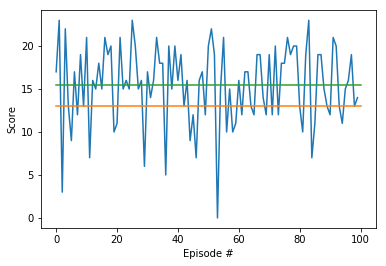

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores) #scores
plt.plot([0,len(scores)], [13,13]) # Criteria Min Value
plt.plot([0,len(scores)], [np.mean(scores[-100:]),np.mean(scores[-100:])]) # Achieved Mean Score over the last 100 eposides
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Ideas for Future Work

So there is few points that I can tackle on further work:
1. Trying different learning algo like SARSA, Expected SARSA.
2. Trying different underlying NN arch than simple one showed above and used in DQN. ie different layers, different neurons / layer,  different activations, drophouts, optimizers, etc
3. Searching for best Hyper-parameters mentioned above, ie smaller learning rate, larger UPDATE_EVERY, etc
4. changing the input from the enviroment space and shifiting to pixels 

When finished, close the environment.

In [ ]:
env.close()